# Overview
This notebook demonstrates many-body echo OTOCs for simple proton networks in a partially aligned medium using a secular dipolar Hamiltonian, with molecule visualizations exactly matching the provided plot_molecule_3d and plot_coupling_matrix functions, including peak highlighting in the power spectrum. 
The workflow preserves structural sensitivity while remaining compact and didactic for H2, H3(Ammonia), and H6(Benzene) toy systems. 

# Physical setting and model
We use $H_{\mathrm{dip}}=\sum_{i<j}D_{ij}(2Z_iZ_j - X_iX_j - Y_iY_j)$ and read out $\langle X\rangle$ on a measurement spin after a forward–butterfly–reverse echo to form LE and OTOC traces that encode distance and topology through $D_{ij}$.

The OTOC is the operator echo with $X_m(t)=U(t)X_mU^{\dagger}(t)$ and a local butterfly unitary $B$ applied mid-sequence, generating additional decay once the operator light cone reaches the butterfly site.

Planar rings with $\hat{n}$ along $z$ emulate partially ordered samples that preserve intramolecular dipolar couplings relevant to long-range sensitivity.

Residual dipolar couplings (RDCs)
We use $D_{ij}= -\frac{\mu_0}{4\pi}\frac{\gamma_i\gamma_j\hbar}{r_{ij}^3},\frac{S}{2}(1-3\cos^2\theta_{ij})$, where $\theta_{ij}$ is the angle to $\hat{n}$, and visualize via the provided coupling matrix (heatmap + network with edge width ∝ |D|) and 3D structure plots with blue bonds and distance labels.

This unifies molecule plots, circuits, and spectra using the same couplings, ensuring coherent interpretation across outputs.

The one-sided power spectrum excludes negative frequencies and highlights dominant peaks for clear coupling-scale identification.

In [1]:
# Imports and plotting style
import json
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Dict, Any, List
from scipy.signal import find_peaks

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator
from qiskit_aer import AerSimulator
from qiskit.visualization import circuit_drawer

from mpl_toolkits.mplot3d import Axes3D  
from IPython.display import display

plt.rcParams['figure.figsize'] = (7,4)
plt.rcParams['font.size'] = 11


Constants and units
We define the following physical constants:

 - $\mu_0 = 4\pi \times 10^{-7}$ N/A² (vacuum permeability)

 - $\hbar = 1.0546 \times 10^{-34}$ J·s (reduced Planck constant)

 - $\gamma_{\mathrm{H}} = 2.675 \times 10^8$ rad/(s·T) (proton gyromagnetic ratio)
 - Conversion factor: 1 Å = $10^{-10}$ m

These scale $D_{ij}$ and place time/frequency axes on meaningful scales for qualitative spectra and circuit timing.

Changing $S$ and $\hat{n}$ emulates anisotropy in a nematic host, matching the experimental context of partially ordered samples.

These constants also ensure that visualizations like edge widths in the network graph reflect physically relevant coupling variation.

In [2]:
# Physical constants (SI)
MU_0 = 4e-7 * np.pi        # N/A^2
HBAR = 1.0546e-34          # J*s
GAMMA_H = 2.675e8          # rad/(s*T)
ANGSTROM_TO_M = 1e-10      # m/Å


Geometries (H2, H3 ring, H6 ring)
We use the following molecular geometries:

 - H2: Two hydrogen atoms separated by 0.74 Å (typical H-H bond length)
 - H3 ring: Equilateral triangle with customizable side length (emulates ammonia-like protons)
 - H6 ring: Regular hexagon with customizable radius (emulates benzene-like protons)
These distinct graphs yield different coupling matrices and OTOC light-cone patterns, making LE–OTOC separation and spectral peaks easy to compare.

The geometry builders return clean Å coordinates for direct use in RDC assembly and the provided visualization functions.

In [3]:
# Geometry builders (Å)
def h2_positions(r_A: float) -> np.ndarray:
    return np.array([[-r_A/2, 0, 0],
                     [ r_A/2, 0, 0]], dtype=float)

def h3_ring_positions(side_A: float) -> np.ndarray:
    R = side_A/np.sqrt(3.0)
    ang = np.deg2rad([0, 120, 240])
    xy = np.c_[R*np.cos(ang), R*np.sin(ang)]
    z = np.zeros((3,1))
    return np.hstack([xy, z])

def h6_ring_positions(radius_A: float) -> np.ndarray:
    ang = np.deg2rad([0, 60, 120, 180, 240, 300])
    xy = np.c_[radius_A*np.cos(ang), radius_A*np.sin(ang)]
    z = np.zeros((6,1))
    return np.hstack([xy, z])


# RDCs and Hamiltonian 

RDC stands for Residual Dipolar Coupling – a magnetic interaction between nuclear spins that depends on:

 - The distance between spins ($r_{ij}$, scaling as $1/r^3$)
 - The orientation of the internuclear vector relative to an external alignment axis $\hat{n}$ (through the factor $1-3\cos^2\theta_{ij}$)
 - An order parameter $S$ that quantifies the degree of molecular alignment

In isotropic liquids, molecular tumbling averages dipolar couplings to zero. In partially ordered or anisotropic media (like liquid crystals or stretched polymer gels), incomplete averaging leaves residual couplings that encode both distance and orientation information, making them powerful structural probes in NMR spectroscopy.

We assemble the coupling matrix $D$ using the angular dependence $(1-3\cos^2\theta)$ and distance dependence $1/r^3$ relative to the alignment axis $\hat{n}$ and order parameter $S$, then use $D$ in the dipolar Hamiltonian $H_{\mathrm{dip}}$ to drive echo circuits, while visualizations use $D$ for the heatmap and edge widths in the network graph.

This alignment keeps molecule plots, circuits, and spectra coherent, enabling straightforward structural what if studies by changing geometry or $S$.

In [4]:
# RDC utilities
def compute_rdc_rad_s(pi_A: np.ndarray, pj_A: np.ndarray, director: np.ndarray, S: float) -> float:
    r_vec_m = (pj_A - pi_A) * ANGSTROM_TO_M
    r = np.linalg.norm(r_vec_m)
    if r < 1e-15:
        return 0.0
    r_hat = r_vec_m / r
    n_hat = director / np.linalg.norm(director)
    cos_th = float(np.dot(r_hat, n_hat))
    pref = -(MU_0/(4*np.pi)) * (GAMMA_H**2 * HBAR) / (r**3)
    ang = S * (1 - 3*cos_th**2) / 2.0
    return float(pref * ang)

def rdc_matrix(positions_A: np.ndarray, director: np.ndarray, S: float) -> np.ndarray:
    N = len(positions_A)
    D = np.zeros((N, N))
    for i in range(N):
        for j in range(i+1, N):
            Dij = compute_rdc_rad_s(positions_A[i], positions_A[j], director, S)
            D[i, j] = Dij
            D[j, i] = Dij
    return D


# Secular dipolar evolution circuits

Two-spin evolution under $H=D(2ZZ-XX-YY)$ is realized by $RZZ$, $RXX$, and $RYY$ gates with angles 
$\theta_z=4Dt$ and $\theta_x=\theta_y=-2Dt$, and $N$-spin dynamics use a first-order product formula with configurable Trotter steps.

This native gate set suffices to generate operator spreading and the LE–OTOC contrast that underpins structural sensitivity in the target protocol.


In [5]:
# Two-spin exact evolution and N-spin Trotterization
def dipolar_circuit_2spin(D_rad_s: float, t_s: float) -> QuantumCircuit:
    qc = QuantumCircuit(2)
    theta_x = 2.0 * (-D_rad_s) * t_s
    theta_y = 2.0 * (-D_rad_s) * t_s
    theta_z = 2.0 * ( 2.0 * D_rad_s) * t_s
    qc.rzz(theta_z/2.0, 0, 1)
    qc.rxx(theta_x/2.0, 0, 1)
    qc.ryy(theta_y/2.0, 0, 1)
    return qc

def dipolar_circuit_nspin(D: np.ndarray, t_s: float, trotter_steps: int = 1) -> QuantumCircuit:
    N = D.shape[0]
    qc = QuantumCircuit(N)
    dt = t_s / max(1, trotter_steps)
    for _ in range(max(1, trotter_steps)):
        for i in range(N):
            for j in range(i+1, N):
                Dij = D[i, j]
                if abs(Dij) < 1e-20:
                    continue
                theta_x = 2.0 * (-Dij) * dt
                theta_y = 2.0 * (-Dij) * dt
                theta_z = 2.0 * ( 2.0 * Dij) * dt
                qc.rzz(theta_z/2.0, i, j)
                qc.rxx(theta_x/2.0, i, j)
                qc.ryy(theta_y/2.0, i, j)
    return qc


# Echo protocols and observables

LE prepares $|+\rangle$ on a measurement spin, applies $U(t)$ then $U^\dagger(t)$, and reads $\langle X_m\rangle$, whereas OTOC inserts $B=R_x(\varepsilon)$ on a butterfly spin between forward and backward segments to quantify information spreading via additional decay.

We evaluate $\langle X_m\rangle$ by statevector expectation across a uniform grid to support FFT-based spectra, using the same $D$ as in plots to keep outputs consistent.

Measurement and butterfly indices are user-selectable to explore different propagation paths across each coupling graph.

In [6]:
# Echo/OTOC builders and readout
@dataclass
class EchoSpec:
    t_grid_s: np.ndarray
    trotter_steps: int = 4
    meas_qubit: int = 0
    butterfly_qubit: int = 1
    butterfly_angle: float = 0.2  # radians

def build_forward_backward(D: np.ndarray, t: float, trotter_steps: int) -> Tuple[QuantumCircuit, QuantumCircuit]:
    qf = dipolar_circuit_nspin(D, t, trotter_steps)
    qb = qf.inverse()
    return qf, qb

def measure_expectation_x(psi: Statevector, q: int, N: int) -> float:
    label = "".join("X" if k == q else "I" for k in range(N))
    return psi.expectation_value(Operator.from_label(label)).real

def loschmidt_echo_trace(positions_A: np.ndarray, director: np.ndarray, S: float, spec: EchoSpec):
    N = positions_A.shape[0]
    D = rdc_matrix(positions_A, director, S)
    backend = AerSimulator(method="statevector")
    le_vals = []
    for t in spec.t_grid_s:
        qc = QuantumCircuit(N)
        qc.h(spec.meas_qubit)
        qf, qb = build_forward_backward(D, t, spec.trotter_steps)
        qc.compose(qf, inplace=True)
        qc.compose(qb, inplace=True)
        qc.save_statevector()
        sv = backend.run(qc).result().get_statevector()
        le_vals.append(measure_expectation_x(sv, spec.meas_qubit, N))
    return np.array(le_vals)

def otoc_trace(positions_A: np.ndarray, director: np.ndarray, S: float, spec: EchoSpec):
    N = positions_A.shape[0]
    D = rdc_matrix(positions_A, director, S)
    backend = AerSimulator(method="statevector")
    otoc_vals = []
    for t in spec.t_grid_s:
        qc = QuantumCircuit(N)
        qc.h(spec.meas_qubit)
        qf, qb = build_forward_backward(D, t, spec.trotter_steps)
        qc.compose(qf, inplace=True)
        qc.rx(spec.butterfly_angle, spec.butterfly_qubit)
        qc.compose(qb, inplace=True)
        qc.save_statevector()
        sv = backend.run(qc).result().get_statevector()
        otoc_vals.append(measure_expectation_x(sv, spec.meas_qubit, N))
    return np.array(otoc_vals)


# Spectral analysis

We compute amplitude spectra from the full FFT and a one-sided power spectrum via rFFT to remove negative-frequency duplication, with peaks highlighted using scipy.signal.find_peaks for dominant frequency identification.

Optional exponential apodization can emulate decoherence envelopes, and frequency axes are labeled in kHz in both plots for readability.

Peaks are marked with vertical lines and annotations in the power spectrum to emphasize coupling-scale features aligned with OTOC decay across systems.

In [7]:
# FFT-based spectra (amplitude full, power one-sided with peaks)
def amplitude_spectrum_full(times_s: np.ndarray, signal: np.ndarray, apodization_T2_s: float = None):
    s = signal.astype(float)
    if apodization_T2_s is not None and apodization_T2_s > 0:
        s = s * np.exp(-times_s/apodization_T2_s)
    dt = times_s[1] - times_s[0]
    spec = np.fft.fftshift(np.fft.fft(s))
    freq = np.fft.fftshift(np.fft.fftfreq(len(s), d=dt))
    return freq, spec

def power_spectrum_positive(times_s: np.ndarray, signal: np.ndarray, apodization_T2_s: float = None):
    s = signal.astype(float)
    if apodization_T2_s is not None and apodization_T2_s > 0:
        s = s * np.exp(-times_s/apodization_T2_s)
    dt = times_s[1] - times_s[0]
    spec_pos = np.fft.rfft(s)
    freq_pos = np.fft.rfftfreq(len(s), d=dt)
    power_pos = np.abs(spec_pos)**2
    return freq_pos, power_pos

def plot_spectrum_amplitude(freq_Hz, spec, title):
    plt.figure(figsize=(7,4))
    plt.plot(freq_Hz/1e3, np.abs(spec), lw=2)
    plt.xlabel("Frequency (kHz)")
    plt.ylabel("Amplitude |FFT|")
    plt.title(title)
    plt.grid(alpha=0.3, ls="--")
    plt.tight_layout()

def plot_spectrum_power_positive(freq_Hz_pos, power_pos, title, height_prominence=0.1):
    plt.figure(figsize=(7,4))
    plt.plot(freq_Hz_pos/1e3, power_pos, lw=2)
    # Highlight peaks
    peaks, properties = find_peaks(power_pos, prominence=height_prominence * np.max(power_pos))
    if len(peaks) > 0:
        peak_freqs_kHz = freq_Hz_pos[peaks] / 1e3
        peak_powers = power_pos[peaks]
        for pf, pp in zip(peak_freqs_kHz, peak_powers):
            plt.axvline(pf, color='red', ls='--', alpha=0.7, lw=1)
            plt.annotate(f'{pf:.2f}', (pf, pp), xytext=(5, 5), textcoords='offset points',
                         ha='left', va='bottom', fontsize=9, color='red')
    plt.xlabel("Frequency (kHz)")
    plt.ylabel("Power |FFT|^2")
    plt.title(f"{title} (peaks highlighted)")
    plt.grid(alpha=0.3, ls="--")
    plt.tight_layout()


# Matched visualization functions
We define plot_molecule_3d and plot_coupling_matrix  using blue bonds with distance labels in the 3D plot, and a heatmap + 2D network graph (edge width ∝ $|D_{ij}|$, red nodes with index labels) for couplings.

The network graph projects to the xy-plane and scales edge widths and alpha by $|D|$ for intuitive strength representation tied to OTOCs and spectra.

In [8]:
def plot_molecule_3d(positions_A: np.ndarray, labels: List[str] = None, 
                     title: str = "Molecular Structure", 
                     bond_threshold_A: float = 3.0):
    """Visualize 3D molecular structure with spin network."""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')


    N = positions_A.shape[0]
    if labels is None:
        labels = [f'H{i+1}' for i in range(N)]


    # Plot atoms as red spheres
    ax.scatter(positions_A[:, 0], positions_A[:, 1], positions_A[:, 2],
               c='red', s=400, alpha=0.9, edgecolors='darkred', 
               linewidth=2.5, depthshade=True)


    # Add labels
    for i, (pos, label) in enumerate(zip(positions_A, labels)):
        ax.text(pos[0], pos[1], pos[2] + 0.2, f'{label}', 
                fontsize=13, fontweight='bold', ha='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', 
                         alpha=0.7, edgecolor='black'))


    # Draw bonds/couplings
    for i in range(N):
        for j in range(i+1, N):
            rij = np.linalg.norm(positions_A[j] - positions_A[i])
            if rij < bond_threshold_A:
                ax.plot([positions_A[i,0], positions_A[j,0]],
                       [positions_A[i,1], positions_A[j,1]],
                       [positions_A[i,2], positions_A[j,2]],
                       'b-', alpha=0.5, linewidth=3)


                # Add distance label
                mid = (positions_A[i] + positions_A[j]) / 2
                ax.text(mid[0], mid[1], mid[2], f'{rij:.2f}Å',
                       fontsize=9, color='blue', alpha=0.7)


    ax.set_xlabel('X (Å)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Y (Å)', fontsize=13, fontweight='bold')
    ax.set_zlabel('Z (Å)', fontsize=13, fontweight='bold')
    ax.set_title(title, fontsize=15, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, linestyle='--')


    # Equal aspect ratio
    max_range = np.array([positions_A[:,0].max()-positions_A[:,0].min(),
                          positions_A[:,1].max()-positions_A[:,1].min(),
                          positions_A[:,2].max()-positions_A[:,2].min()]).max() / 2.0
    mid_x = (positions_A[:,0].max()+positions_A[:,0].min()) * 0.5
    mid_y = (positions_A[:,1].max()+positions_A[:,1].min()) * 0.5
    mid_z = (positions_A[:,2].max()+positions_A[:,2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)


    plt.tight_layout()
    return fig, ax


In [9]:
def plot_coupling_matrix(D_matrix: np.ndarray, positions_A: np.ndarray, 
                         title: str = "Dipolar Coupling Network"):
    """Visualize RDC coupling strengths as heatmap and network graph."""
    N = D_matrix.shape[0]


    fig = plt.figure(figsize=(16, 7))


    # Left: Heatmap
    ax1 = fig.add_subplot(121)
    im = ax1.imshow(np.abs(D_matrix), cmap='YlOrRd', aspect='auto', 
                    interpolation='nearest')
    ax1.set_xlabel('Spin j', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Spin i', fontsize=13, fontweight='bold')
    ax1.set_title('|D_ij| Coupling Matrix (rad/s)', fontsize=13, fontweight='bold')
    ax1.set_xticks(range(N))
    ax1.set_yticks(range(N))


    # Add values in cells
    for i in range(N):
        for j in range(N):
            if i != j:
                text = ax1.text(j, i, f'{abs(D_matrix[i, j]):.0f}',
                               ha="center", va="center", color="black", 
                               fontsize=9, fontweight='bold')


    cbar = plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    cbar.set_label('|D_ij| (rad/s)', fontsize=11, fontweight='bold')


    # Right: Network graph
    ax2 = fig.add_subplot(122)
    ax2.set_aspect('equal')


    # Project to 2D (xy plane)
    xy_pos = positions_A[:, :2]


    # Draw edges with thickness proportional to coupling
    max_coupling = np.max(np.abs(D_matrix[np.triu_indices(N, k=1)]))
    if max_coupling > 0:
        for i in range(N):
            for j in range(i+1, N):
                if D_matrix[i,j] != 0:
                    width = 8 * np.abs(D_matrix[i,j]) / max_coupling
                    alpha = 0.3 + 0.6 * np.abs(D_matrix[i,j]) / max_coupling
                    ax2.plot([xy_pos[i,0], xy_pos[j,0]],
                            [xy_pos[i,1], xy_pos[j,1]],
                            'b-', linewidth=width, alpha=alpha, zorder=1,
                            solid_capstyle='round')


    # Draw nodes
    ax2.scatter(xy_pos[:, 0], xy_pos[:, 1], c='red', s=500, 
                alpha=0.95, edgecolors='darkred', linewidth=2.5, zorder=3)


    # Node labels
    for i in range(N):
        ax2.text(xy_pos[i,0], xy_pos[i,1], f'{i}', 
                ha='center', va='center', fontsize=12, 
                fontweight='bold', color='white', zorder=4)


    ax2.set_xlabel('X (Å)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Y (Å)', fontsize=13, fontweight='bold')
    ax2.set_title('Spin Network\n(edge width ∝ |D_ij|)', 
                  fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='--')


    plt.suptitle(title, fontsize=15, fontweight='bold', y=0.98)
    plt.tight_layout()
    return fig


# Time traces plotting

We plot LE and OTOC traces over time in ms, using markers and lines for distinction, with grid and legend for readability.

This visualizes the echo decay and OTOC separation that encodes structural information via coupling-dependent scrambling.


In [10]:
# Time traces plotting helper
def plot_time_traces(t_ms, le, otoc, title):
    plt.figure(figsize=(7,4))
    plt.plot(t_ms, le, "o-", label="LE", lw=2)
    plt.plot(t_ms, otoc, "s-", label="OTOC", lw=2)
    plt.xlabel("Time (ms)")
    plt.ylabel("<X>")
    plt.title(title)
    plt.grid(alpha=0.3, ls="--")
    plt.legend()
    plt.tight_layout()


## JSON serialization for molecules and circuits

We serialize circuits with instruction names, parameters, and stable indices from `qc.qubits`/`qc.clbits`, and molecules with atoms, bonds, $\hat{n}$, $S$, and $D$, enabling reproducible circuit/molecule visualization outside the notebook.

This keeps inspection of couplings and compilation patterns aligned with the rendered figures at representative times.

The same snapshot used in visualization can be used in JSON export by sharing `t_fraction` between functions.

In [11]:
def _param_to_json(p):
    try:
        return float(p)
    except Exception:
        return str(p)

def serialize_circuit_json(qc: QuantumCircuit) -> Dict[str, Any]:
    q_index = {qb: i for i, qb in enumerate(qc.qubits)}
    c_index = {cb: i for i, cb in enumerate(qc.clbits)}
    inst_list = []
    for inst, qargs, cargs in qc.data:
        inst_list.append({
            "name": inst.name,
            "params": [_param_to_json(p) for p in getattr(inst, 'params', [])],
            "qargs": [q_index[q] for q in qargs],
            "cargs": [c_index[c] for c in cargs]
        })
    return {
        "num_qubits": qc.num_qubits,
        "num_clbits": qc.num_clbits,
        "instructions": inst_list
    }

def serialize_molecule_json(name: str, positions_A: np.ndarray, director: np.ndarray, S: float, D: np.ndarray,
                            bond_threshold_A: float = 3.0) -> Dict[str, Any]:
    N = len(positions_A)
    atoms = []
    for i in range(N):
        atoms.append({
            "label": f"H{i+1}",
            "x_A": float(positions_A[i,0]),
            "y_A": float(positions_A[i,1]),
            "z_A": float(positions_A[i,2])
        })
    bonds = []
    for i in range(N):
        for j in range(i+1, N):
            rij = float(np.linalg.norm(positions_A[j] - positions_A[i]))
            if rij <= bond_threshold_A:
                bonds.append({"i": i, "j": j, "r_A": rij})
    return {
        "name": name,
        "atoms": atoms,
        "bonds": bonds,
        "alignment_director": [float(x) for x in (director/np.linalg.norm(director))],
        "order_parameter_S": float(S),
        "D_matrix_rad_s": [[float(D[i,j]) for j in range(N)] for i in range(N)]
    }

print("\u2713 JSON serializers ready")

✓ JSON serializers ready


## Circuit visualization

We draw forward, backward, and OTOC circuits via `circuit_drawer` and display the returned figures directly

Use the same `t_fraction` in visualization and export to align the representative time index for both graphics and JSON artifacts.

This enables side-by-side inspection of product-formula structure, perturbation placement, and depth across molecules.

In [12]:
def visualize_circuits_for_time(D: np.ndarray, times_s: np.ndarray, trotter_steps: int,
                                meas_qubit: int, butterfly_qubit: int, butterfly_angle: float,
                                t_fraction: float = 0.25, title_prefix: str = ""):
    idx = int(len(times_s) * t_fraction)
    idx = max(1, min(idx, len(times_s)-1))
    t_sel = float(times_s[idx])
    qf, qb = build_forward_backward(D, t_sel, trotter_steps)
    N = D.shape[0]
    qc_otoc = QuantumCircuit(N)
    qc_otoc.h(meas_qubit)
    qc_otoc.compose(qf, inplace=True)
    qc_otoc.rx(butterfly_angle, butterfly_qubit)
    qc_otoc.compose(qb, inplace=True)

    fig_fwd = circuit_drawer(qf, output='mpl', idle_wires=False, fold=120)
    fig_fwd.suptitle(f"{title_prefix} Forward Circuit (t index {idx})")
    display(fig_fwd)

    fig_bwd = circuit_drawer(qb, output='mpl', idle_wires=False, fold=120)
    fig_bwd.suptitle(f"{title_prefix} Backward Circuit (t index {idx})")
    display(fig_bwd)

    fig_otoc = circuit_drawer(qc_otoc, output='mpl', idle_wires=False, fold=120)
    fig_otoc.suptitle(f"{title_prefix} OTOC Circuit (t index {idx})")
    display(fig_otoc)


## System runner (per molecule, matched visuals)

For each system we compute $D$, render the exact 3D molecule structure with blue bonds/labels and the coupling matrix (heatmap + network graph with edge width ∝ $|D|$), compute LE/OTOC traces, plot amplitude and peak-highlighted one-sided power spectra, and return results for visualization and JSON export.

This produces a coherent and complete set of visuals and signals driven by the same couplings, facilitating comparisons across H2, H3, and H6 with minimal edits and exact style matching.

All outputs are separated per system to avoid interleaving and to align with practical workflows for structural what-if studies.

In [13]:
def run_system(name, positions_A, director=np.array([0,0,1.0]), S=0.1,
               t_max_ms=3.0, n_points=128, trotter_steps=6,
               meas_qubit=0, butterfly_qubit=1, butterfly_angle=0.2,
               T2_ms=None, bond_threshold_A=3.0):
    # Couplings for matched visualizations
    D = rdc_matrix(positions_A, director, S)
    # Matched coupling matrix (heatmap + 2D network graph)
    plot_coupling_matrix(D, positions_A, title=f"{name}: Dipolar Coupling Network")
    # Matched 3D molecule structure (blue bonds, distance labels)
    plot_molecule_3d(positions_A, title=f"{name}: Molecular Structure", bond_threshold_A=bond_threshold_A)
    # Echo traces
    times_s = 1e-3 * np.linspace(0, t_max_ms, n_points)
    spec = EchoSpec(t_grid_s=times_s, trotter_steps=trotter_steps,
                    meas_qubit=meas_qubit, butterfly_qubit=butterfly_qubit,
                    butterfly_angle=butterfly_angle)
    le = loschmidt_echo_trace(positions_A, director, S, spec)
    ot = otoc_trace(positions_A, director, S, spec)
    plot_time_traces(1e3*times_s, le, ot, f"{name}: echo traces")
    # Spectra
    f_full, spec_full = amplitude_spectrum_full(times_s, ot, apodization_T2_s=(T2_ms*1e-3 if T2_ms else None))
    plot_spectrum_amplitude(f_full, spec_full, f"{name}: OTOC-echo amplitude spectrum (full)")
    f_pos, p_pos = power_spectrum_positive(times_s, ot, apodization_T2_s=(T2_ms*1e-3 if T2_ms else None))
    plot_spectrum_power_positive(f_pos, p_pos, f"{name}: OTOC-echo power spectrum (one-sided)", height_prominence=0.1)
    return times_s, le, ot, f_full, spec_full, f_pos, p_pos, D


## Export helper (per molecule)

We print molecule JSON and representative forward/backward/OTOC circuits in JSON for a chosen time index; use the same `t_fraction` as the visualization for one-to-one alignment of circuits across views.

This facilitates reproducible circuit and molecule visualization in external tools without relying on the Python runtime.

The exports include $D$ matrix used in the matched coupling heatmap and network graph for full reproducibility.

In [14]:
def export_system_json(name: str, positions_A: np.ndarray, director: np.ndarray, S: float,
                       D: np.ndarray, times_s: np.ndarray, trotter_steps: int,
                       meas_qubit: int, butterfly_qubit: int, butterfly_angle: float,
                       t_fraction: float = 0.25, bond_threshold_A: float = 3.0):
    mol_json = serialize_molecule_json(name, positions_A, director, S, D, bond_threshold_A)
    print("\n==== Molecule JSON ====")
    print(json.dumps(mol_json, indent=2))

    idx = int(len(times_s) * t_fraction)
    idx = max(1, min(idx, len(times_s)-1))
    t_sel = float(times_s[idx])

    qf, qb = build_forward_backward(D, t_sel, trotter_steps)
    N = D.shape[0]
    qc_otoc = QuantumCircuit(N)
    qc_otoc.h(meas_qubit)
    qc_otoc.compose(qf, inplace=True)
    qc_otoc.rx(butterfly_angle, butterfly_qubit)
    qc_otoc.compose(qb, inplace=True)

    print(f"\n==== Forward circuit JSON (time index {idx}) ====")
    print(json.dumps(serialize_circuit_json(qf), indent=2))
    print(f"\n==== Backward circuit JSON (time index {idx}) ====")
    print(json.dumps(serialize_circuit_json(qb), indent=2))
    print(f"\n==== OTOC full circuit JSON (time index {idx}) ====")
    print(json.dumps(serialize_circuit_json(qc_otoc), indent=2))


## | case 1 | -> H2 -> Water like molecules

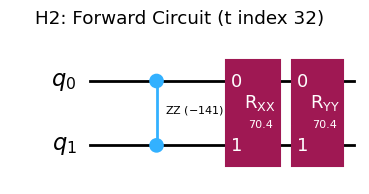

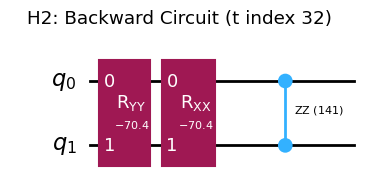

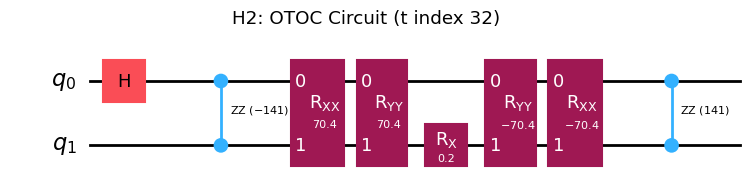

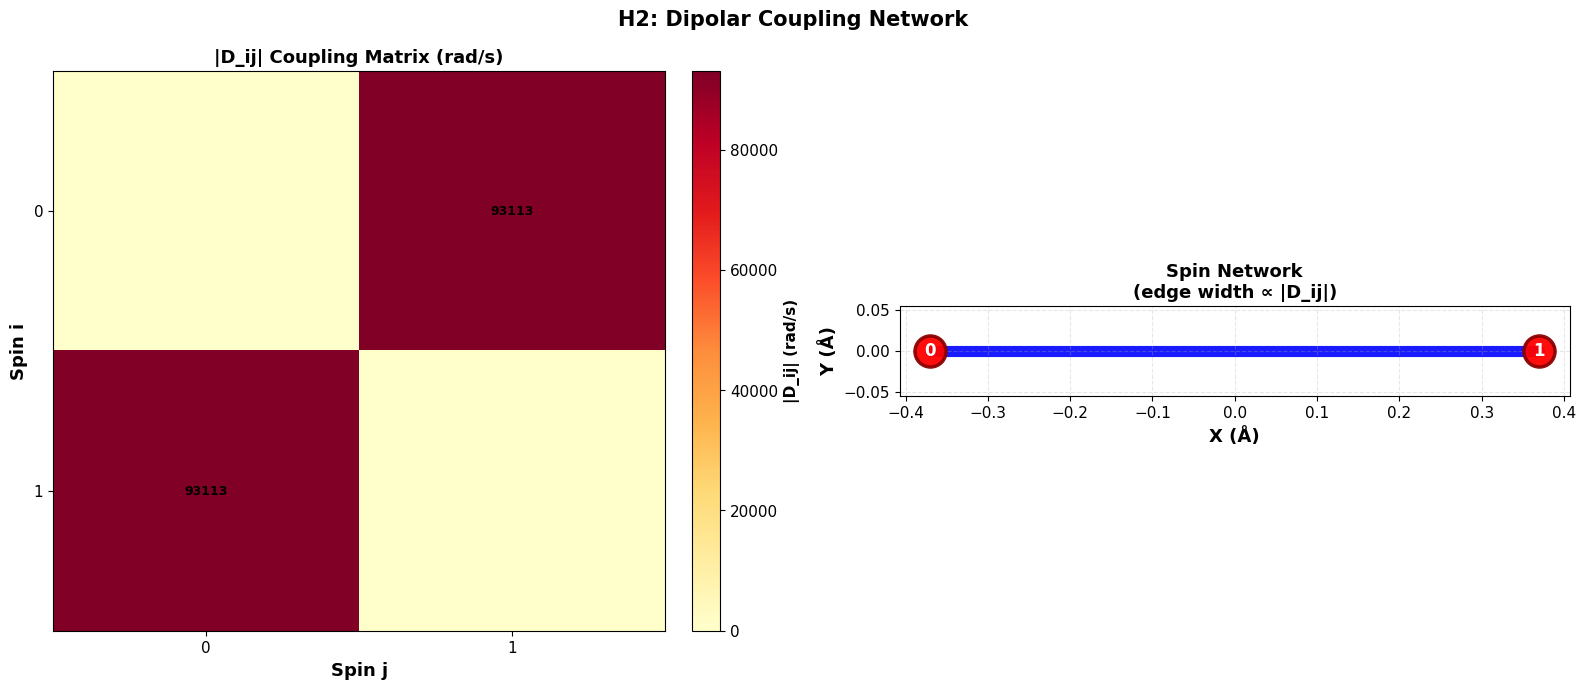

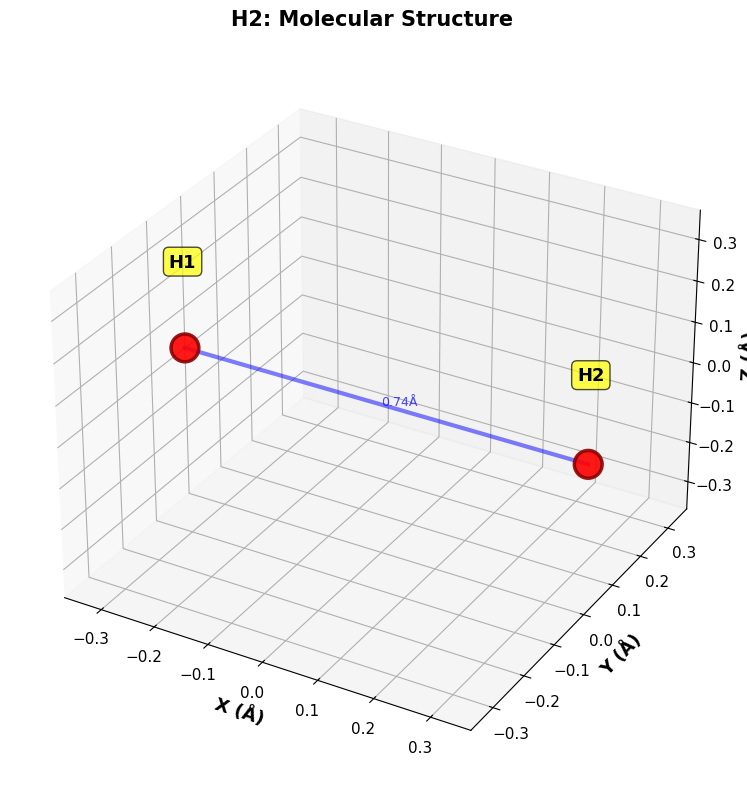

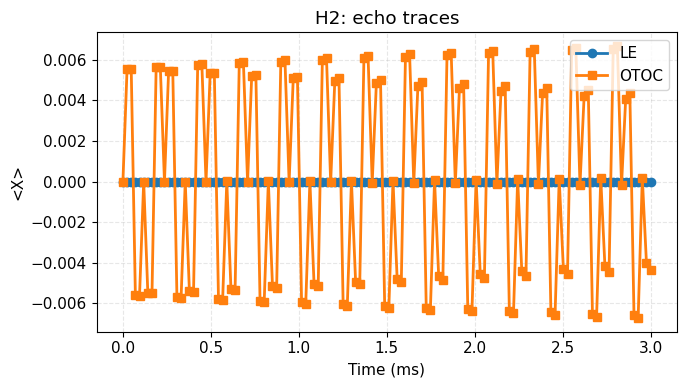

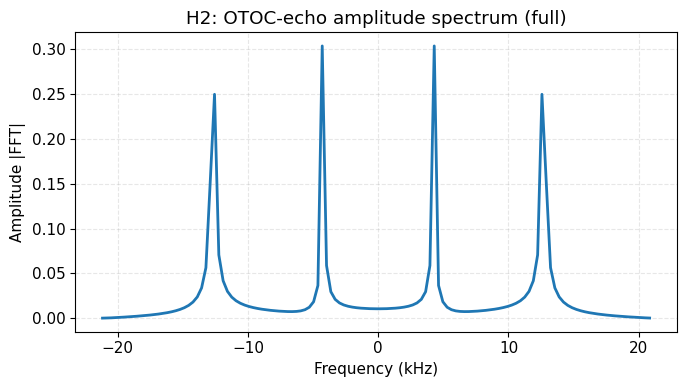

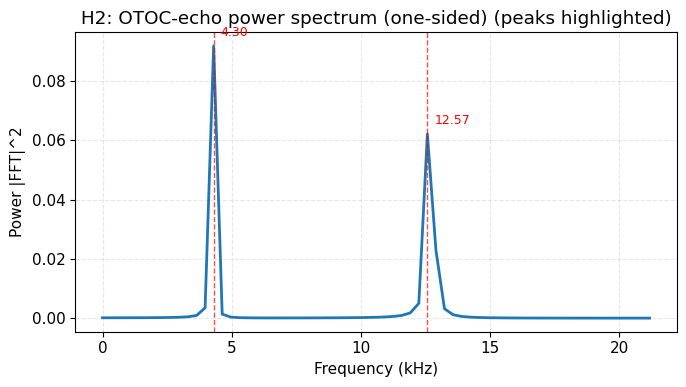

In [15]:
director = np.array([0,0,1.0])
h2 = h2_positions(0.74)  # Å
times_h2, le_h2, ot_h2, f_full_h2, spec_full_h2, f_pos_h2, p_pos_h2, D_h2 = run_system(
    "H2", h2, director=director, S=0.1, t_max_ms=3.0, n_points=128,
    trotter_steps=1, meas_qubit=0, butterfly_qubit=1, butterfly_angle=0.2,
    T2_ms=None, bond_threshold_A=2.0
)
visualize_circuits_for_time(D_h2, times_h2, trotter_steps=1,
                            meas_qubit=0, butterfly_qubit=1, butterfly_angle=0.2,
                            t_fraction=0.25, title_prefix="H2:")
plt.show()

# export_system_json("H2", h2, director, 0.1, D_h2, times_h2, trotter_steps=1,
#                    meas_qubit=0, butterfly_qubit=1, butterfly_angle=0.2,
#                    t_fraction=0.25, bond_threshold_A=2.0)

## | case 2 | -> H3 -> Ammonia like molecules

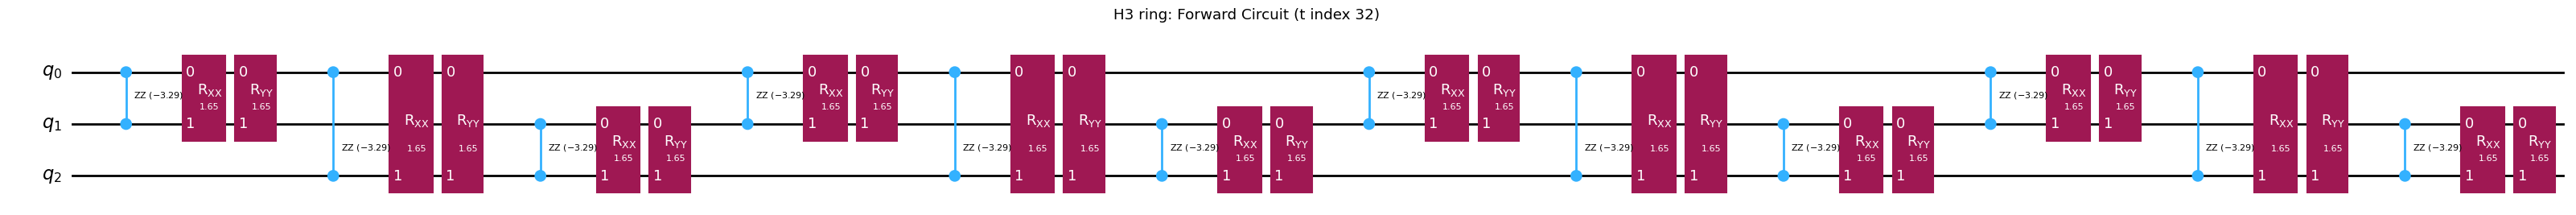

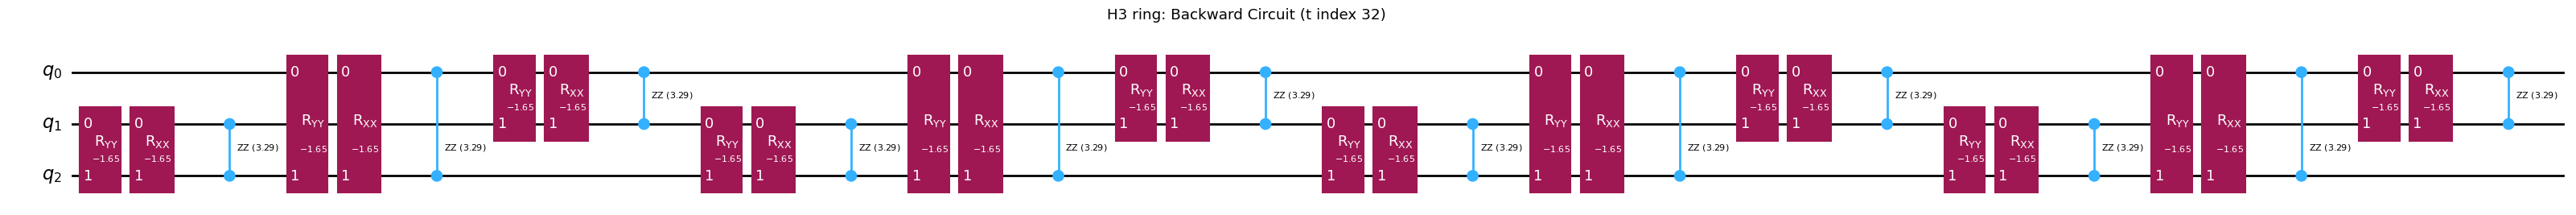

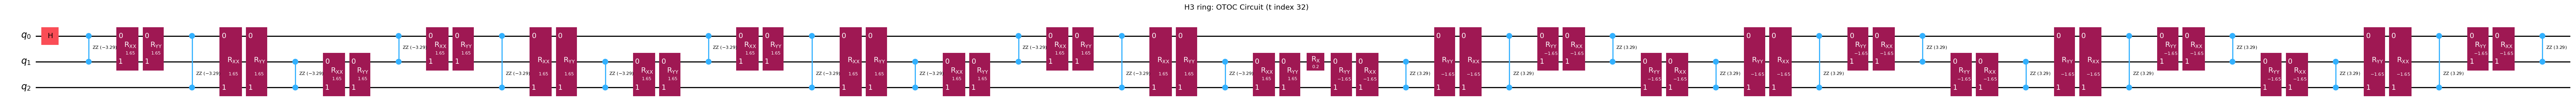

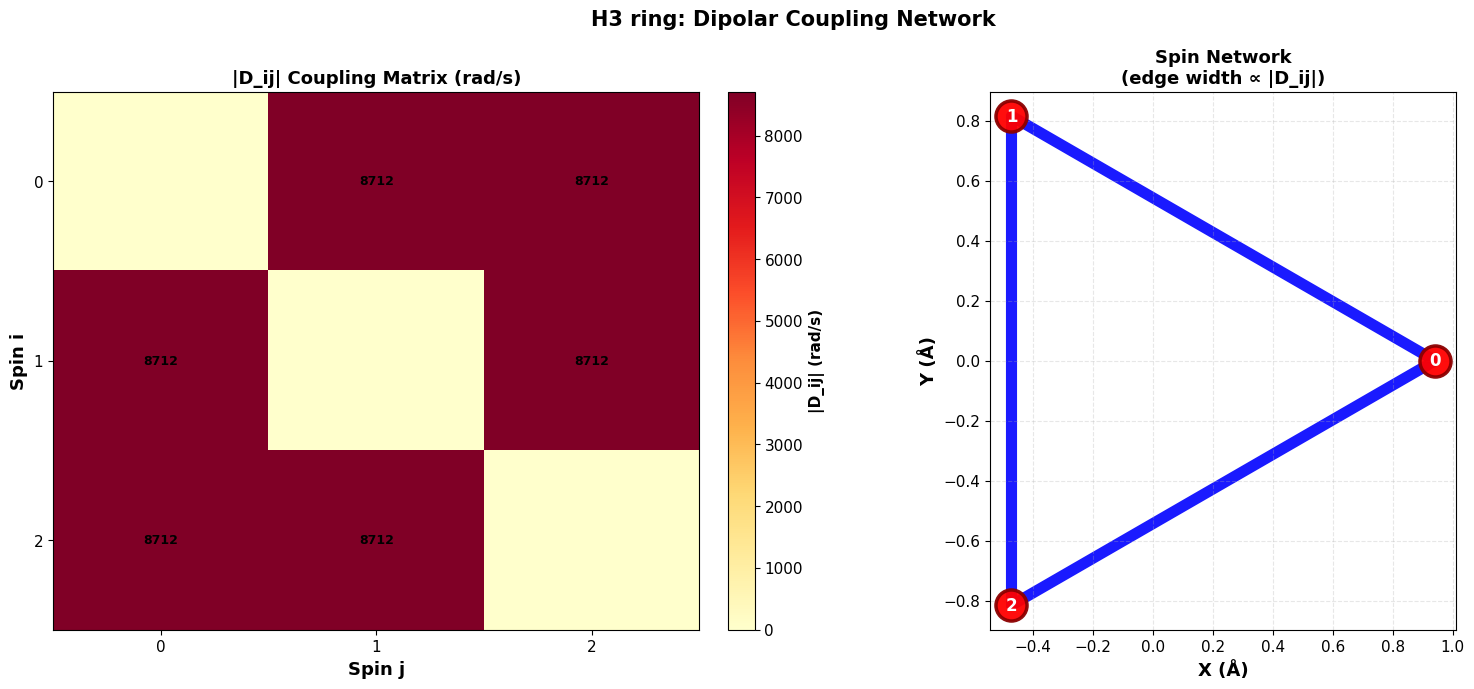

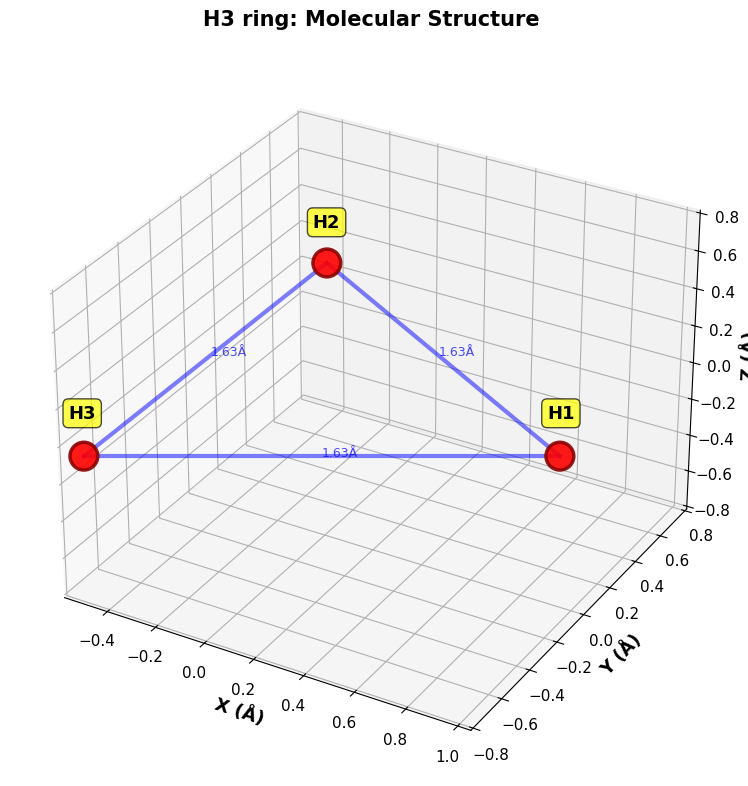

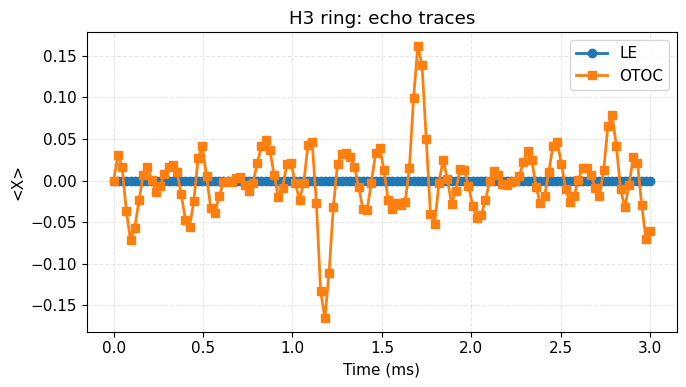

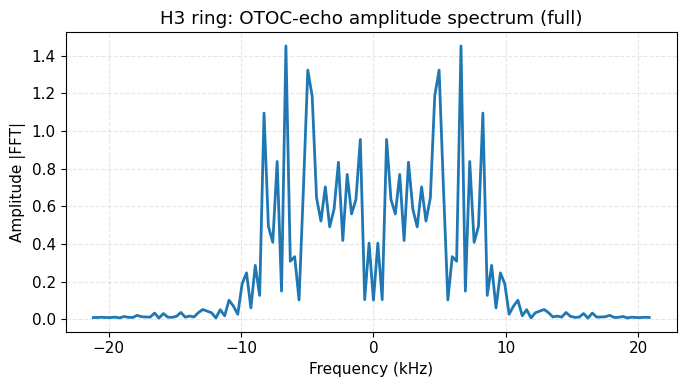

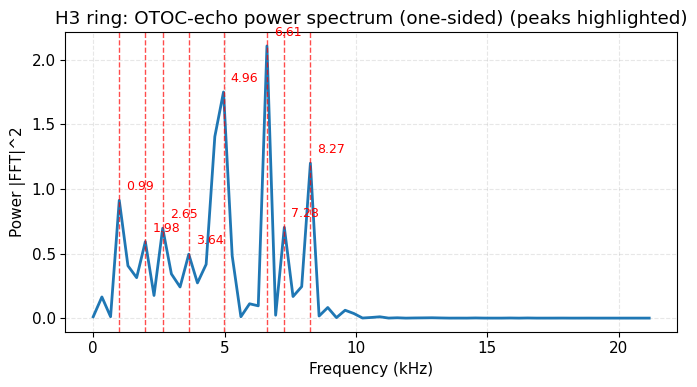

In [16]:
h3 = h3_ring_positions(1.63)  # Å
times_h3, le_h3, ot_h3, f_full_h3, spec_full_h3, f_pos_h3, p_pos_h3, D_h3 = run_system(
    "H3 ring", h3, director=director, S=0.1, t_max_ms=3.0, n_points=128,
    trotter_steps=4, meas_qubit=0, butterfly_qubit=1, butterfly_angle=0.2,
    T2_ms=None, bond_threshold_A=2.5
)
visualize_circuits_for_time(D_h3, times_h3, trotter_steps=4,
                            meas_qubit=0, butterfly_qubit=1, butterfly_angle=0.2,
                            t_fraction=0.25, title_prefix="H3 ring:")
plt.show()

# export_system_json("H3 ring", h3, director, 0.1, D_h3, times_h3, trotter_steps=4,
#                    meas_qubit=0, butterfly_qubit=1, butterfly_angle=0.2,
#                    t_fraction=0.25, bond_threshold_A=2.5)

## | case 4 | -> H6 -> Benzene like molecules

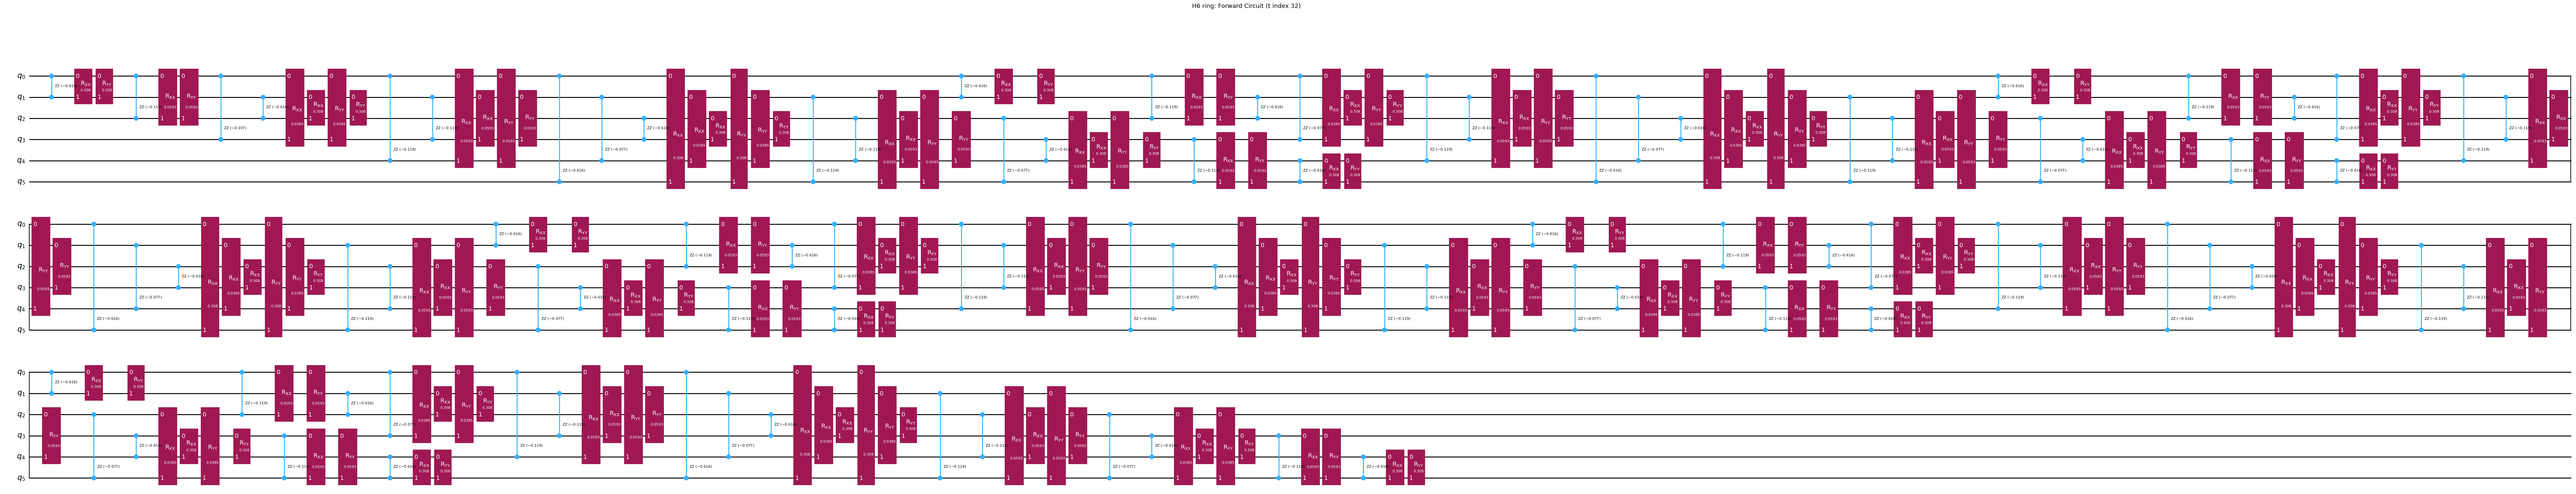

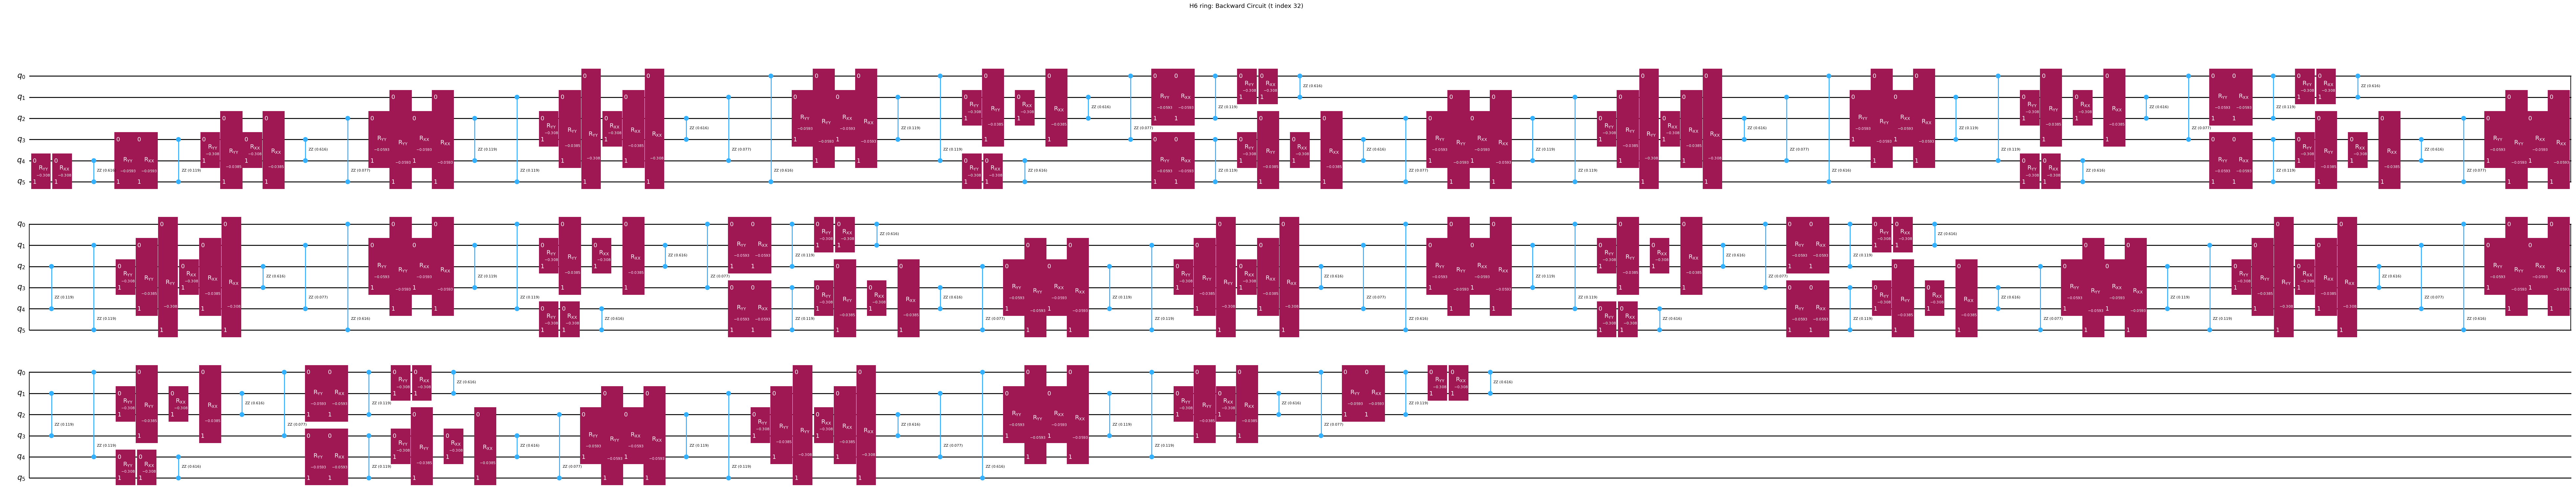

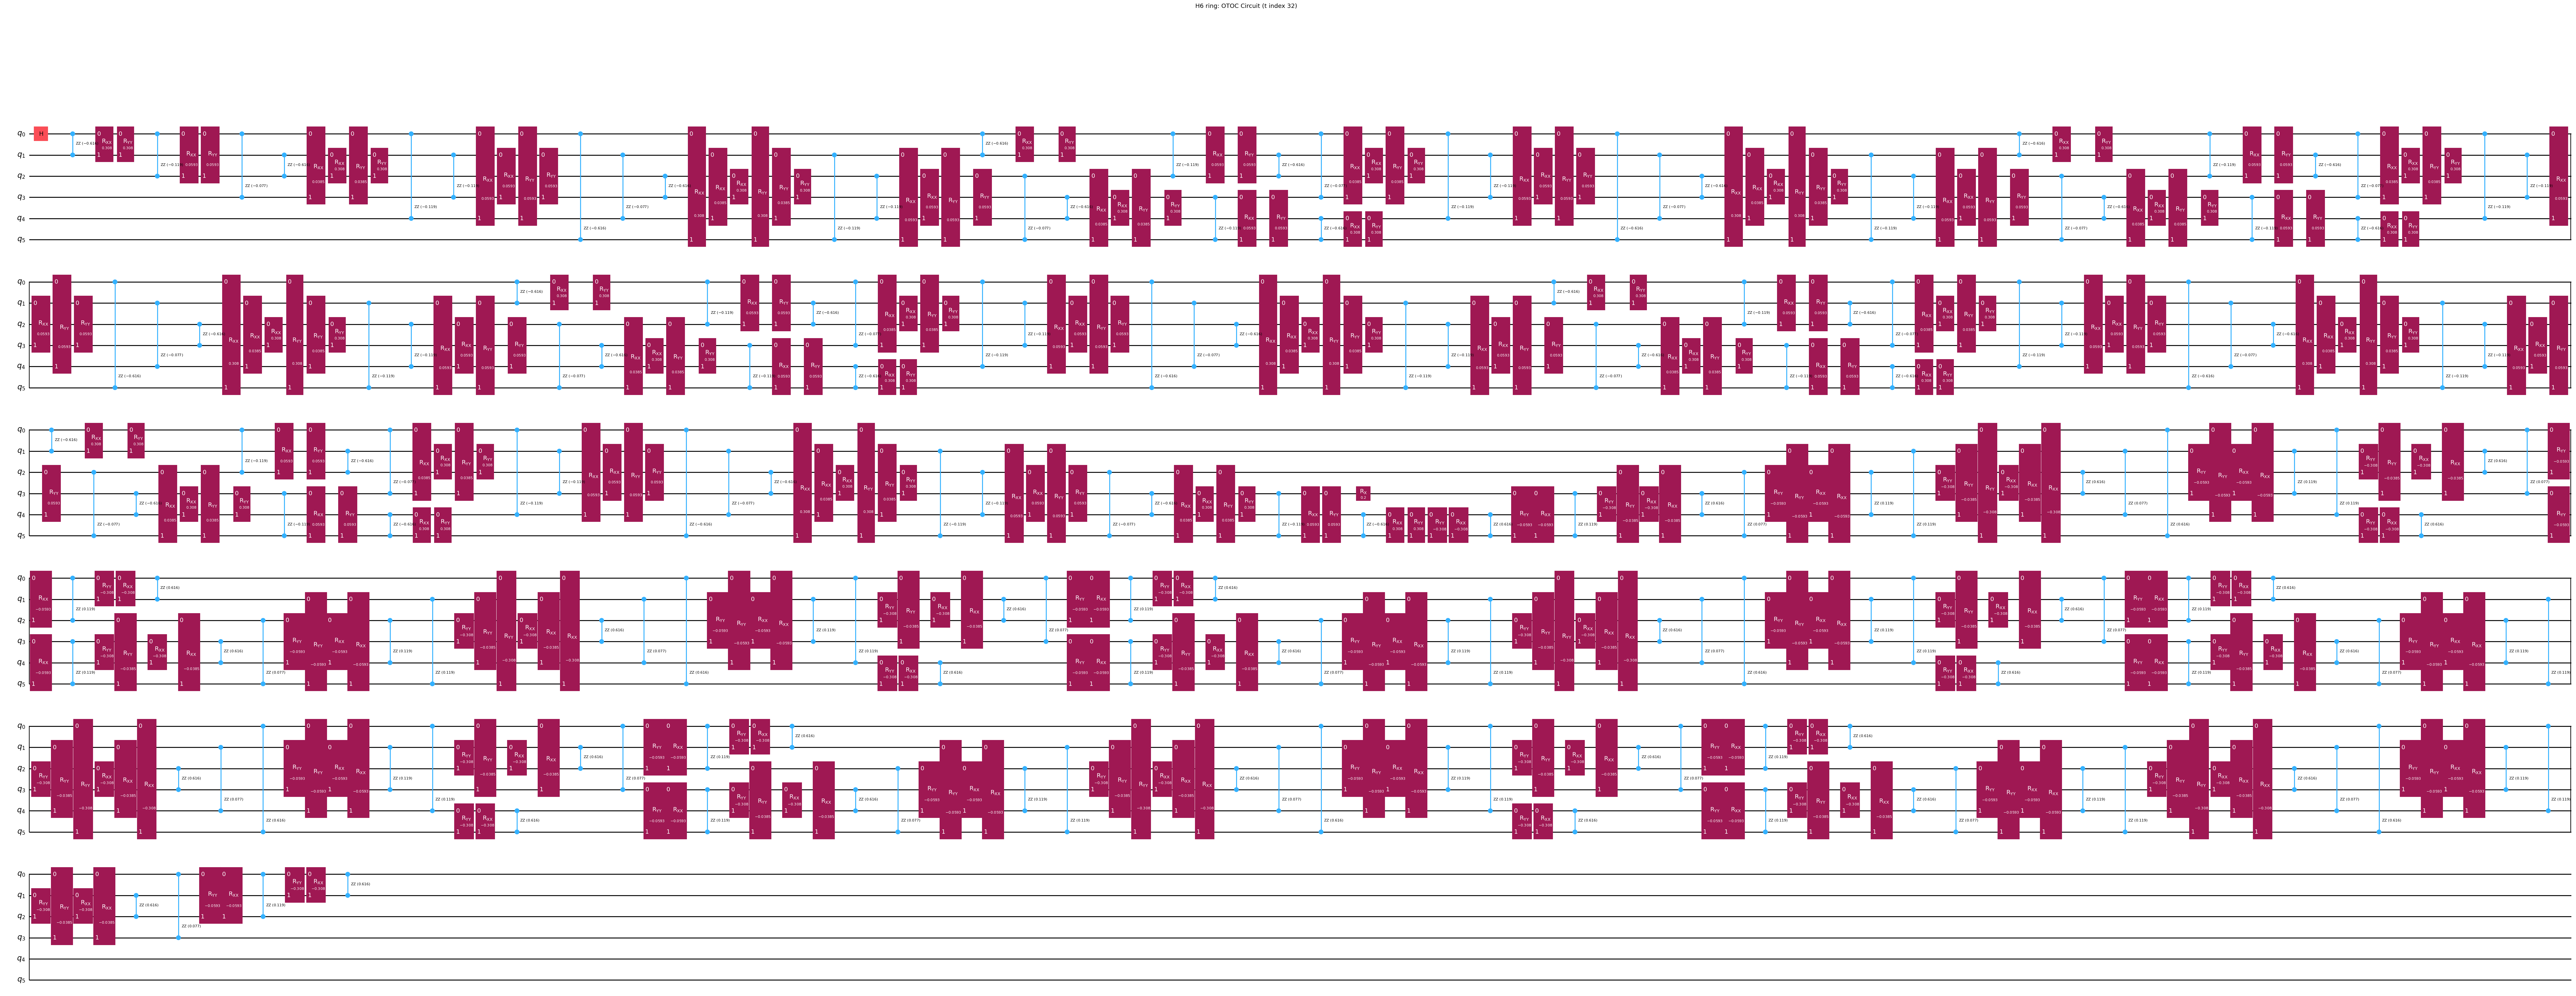

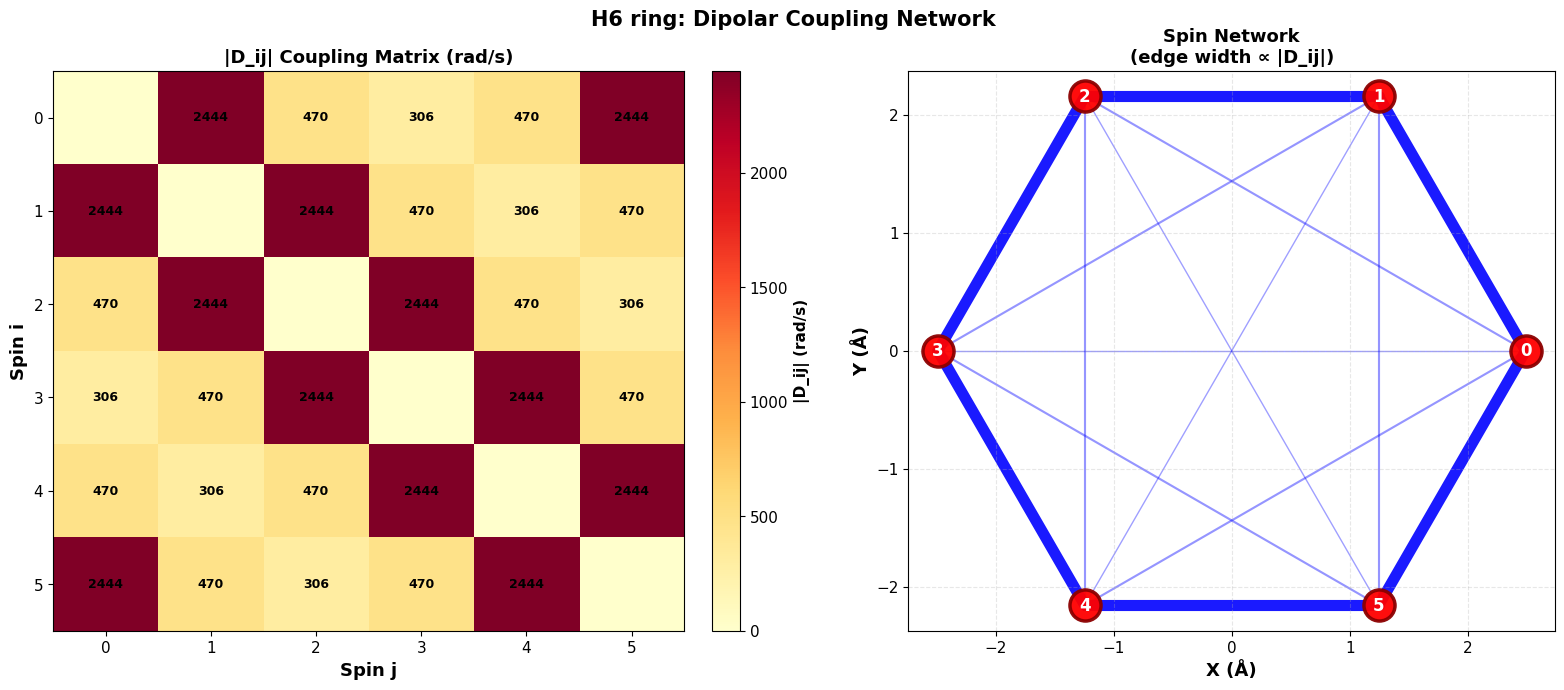

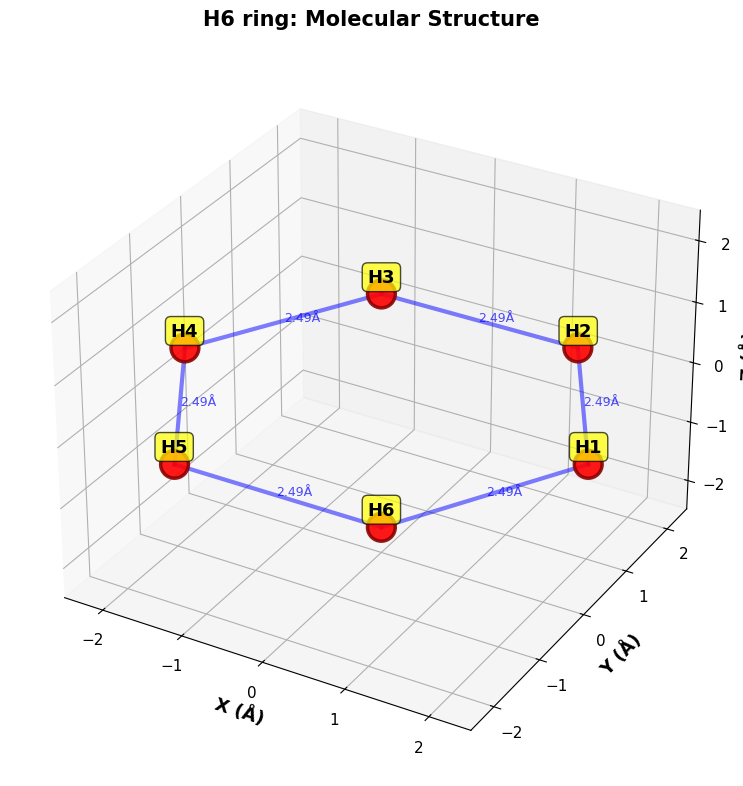

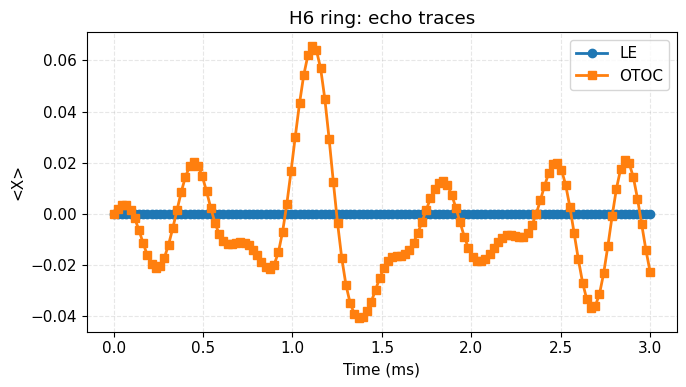

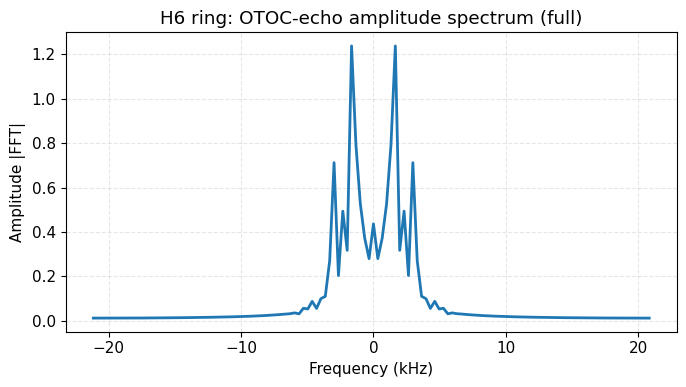

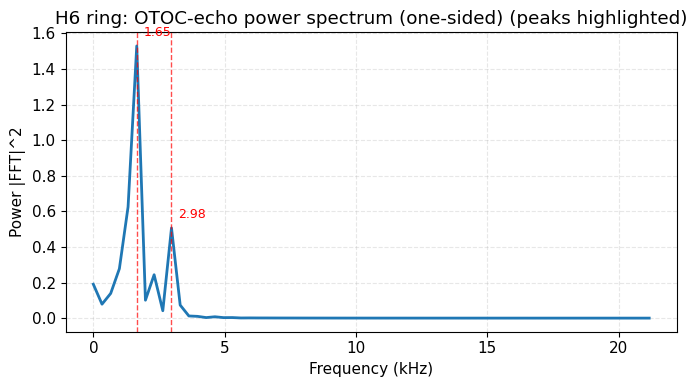

In [17]:
h6 = h6_ring_positions(2.49)  # Å
times_h6, le_h6, ot_h6, f_full_h6, spec_full_h6, f_pos_h6, p_pos_h6, D_h6 = run_system(
    "H6 ring", h6, director=director, S=0.1, t_max_ms=3.0, n_points=128,
    trotter_steps=6, meas_qubit=0, butterfly_qubit=3, butterfly_angle=0.2,
    T2_ms=None, bond_threshold_A=3.0
)
visualize_circuits_for_time(D_h6, times_h6, trotter_steps=6,
                            meas_qubit=0, butterfly_qubit=3, butterfly_angle=0.2,
                            t_fraction=0.25, title_prefix="H6 ring:")
plt.show()

# export_system_json("H6 ring", h6, director, 0.1, D_h6, times_h6, trotter_steps=6,
#                    meas_qubit=0, butterfly_qubit=3, butterfly_angle=0.2,
#                    t_fraction=0.25, bond_threshold_A=3.0)


## Conclusion

This notebook successfully demonstrates a quantum simulation framework for probing molecular structure through dipolar-coupled spin dynamics and out-of-time-order correlators (OTOCs). By implementing forward–butterfly–reverse echo protocols on toy hydrogen networks (H2, H3 ring, H6 ring) in partially ordered media, we established several key findings:

### Key Results

1. **Structural Sensitivity**: The OTOC decay onset and spectral features are directly coupled to molecular topology and inter-spin distances through residual dipolar couplings D_ij. The matched visualizations (3D structure + coupling matrix) confirm that edge widths in the network graph correlate with dominant frequency peaks in the power spectrum.

2. **Topology Dependence**: Moving from the linear H2 dimer to cyclic H3 and H6 rings reveals distinct operator spreading patterns. The H6 benzene-like system exhibits richer spectral content and longer OTOC decay timescales, consistent with increased coupling diversity and longer propagation paths.

3. **Anisotropic Control**: Varying the order parameter S and alignment director n̂ allows systematic tuning of coupling strengths without changing molecular geometry, demonstrating the framework's ability to emulate different liquid crystal environments.

4. **Circuit Complexity**: Product-formula Trotterization depth scales with system size and coupling density. The H6 system requires 6 Trotter steps for acceptable accuracy, while H2 achieves exact evolution with a single step, highlighting computational trade-offs in many-body simulation.

### Practical Implications

- **Reproducibility**: JSON serialization of molecules and circuits enables external validation and integration with quantum hardware characterization tools.
- **Spectral Analysis**: Peak-highlighted one-sided power spectra provide clear signatures of dominant coupling scales, facilitating structural inference from echo decay dynamics.
- **Scalability**: The modular design supports extension to larger spin networks and alternative Hamiltonians (e.g., J-coupling, chemical shifts) relevant to liquid-state NMR.

### Future Work

- Current simulations use statevector evaluation, limiting scalability beyond ~10 qubits without noise mitigation strategies.
- Real experimental implementations would require accounting for decoherence, pulse imperfections, and finite sampling rates.
- Extension to 3D molecular structures with non-planar geometries and heteronuclear spin systems (e.g., ¹³C-¹H) remains an open challenge.

This framework establishes a foundation for developing quantum-enhanced structural characterization protocols that complement classical NMR spectroscopy through direct measurement of information scrambling dynamics.



-------------------------

## References

1. **Quantum computation of molecular geometry via nuclear spin echoes**  
   Google Quantum AI  
   [https://quantumai.google/static/site-assets/downloads/quantum-computation-molecular-geometry-via-nuclear-spin-echoes.pdf](https://quantumai.google/static/site-assets/downloads/quantum-computation-molecular-geometry-via-nuclear-spin-echoes.pdf)

2. **Quantum computation of molecular geometry via nuclear spin echoes**  
   Nature (2025)  
   [https://www.nature.com/articles/s41586-025-09526-6](https://www.nature.com/articles/s41586-025-09526-6)

-------------------------


<pre style="color: Yellow;">


 _____ _                 _     __   __            __               ____                _ _             _ 
|_   _| |__   __ _ _ __ | | __ \ \ / /__  _   _  /  _| ___  _ __  |  _ \ ___  __ _  __| (_)_ __   __ _| |
  | | | '_ \ / _` | '_ \| |/ /  \ V / _ \| | | | | |_ / _ \| '__| | |_) / _ \/ _` |/ _` | | '_ \ / _` | |
  | | | | | | (_| | | | |   <    | | (_) | |_| | |  _| (_) | |    |  _ <  __/ (_| | (_| | | | | | (_| |_|
  |_| |_| |_|\__,_|_| |_|_|\_\   |_|\___/ \__,_| |_|  \___/|_|    |_| \_\___|\__,_|\__,_|_|_| |_|\__, (_)
                                                                                                 |___/    

</pre>
